In [16]:
# If you get a "No module named 'matplotlib'" error, you might have to
# install matplotlib before running this line. To do so, go to the
# terminal, activate your virtual environment, and then run
#
# pip install matplotlib

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import pylab

# You might also need to install numpy. Same thing:
# pip install numpy
import numpy as np

# Hopefully, you'll have sklearn installed from the last class
import sklearn
import sklearn.neighbors
from sklearn import linear_model

Going back to the Learning Algorithms
================================

In the last class, we have spoken about the problem of Classification. In a few words, we were given:

 * An input space $I$.
 * A set of labels $C = \{c_1, c_2, \ldots, c_m \}$.
 * A dataset containing pairs $(d_i, l_i),~~i=1, \ldots, k$, where $d_i \in I$ and $l_i \in C$.

Our goal was then to find a model $f: I \rightarrow C$ that, given a new (_unseen_) $d$, is capable of predicting its correct $l$ (i.e., $f(d) = l$).

We talked a little about overfitting, and noise, and about how to split our data, and how to measure classification performance.

Our goal now is to understand how our goal is achieved.


Training
========

Example Dataset
---------------

To make this easier to understand, we will create a very simple dataset. In this fictitious dataset, different participants read some sentences and had their eye tracked by a camera in front of them.

Say our data looks like the following...

In [113]:
# Generates some fictitious data

columns = ["gender",
           "mean_pupil_dilation",
           "total_reading_time",
           "num_fixations"]

data = [
    ['M',   0.90,  120,  20],
    ['F',   0.89,  101,  18],
    ['M',   0.79,  104,  24],
    ['F',   0.91,  111,  19],
    ['F',   0.77,   95,  20],
    ['F',   0.63,   98,  22],
    ['M',   0.55,   77,  30],
    ['M',  0.60,   80,  23],
    ['M',  0.55,   67,  56],
    ['F',  0.54,   63,  64],
    ['M',  0.45,   59,  42],
    ['M',  0.44,   57,  43],
    ['F',  0.40,   61,  51],
    ['F',  0.39,   66,  40]
]

test_data = [
    ['M',   0.87,  102,  17],
    ['F',   0.74,  101,  12],
    ['M',  0.42,   60,  52],
    ['F',  0.36,   54,  44]
]

Regression
----------

Before talking about how classification is learnt, it pays off to talk a little about a very similar and closely related problem: Regression.

If you look at our data, you will see that the people with ASD take longer to read and have a much higher pupil dilation than the people without ASD. It makes sense to ask: is it possible to guess more or less the `mean_pupil_dilation` only from the `total_reading_time`? Guessing the value of a continuous variable from the value of other continuous variables is what is known in Machine Learning as _Regression_.

In more formal terms, following the same structure of the definition of Classification, we will define Regression as follows. Given:

 * An input space $I$.
 * A dataset containing pairs $(d_i, l_i),~~i=1, \ldots, k$, where $d_i \in I$ and $l_i \in \mathbb{R}$.

Our goal was then to find a model $f: I \rightarrow \mathbb{R}$ that, given a new (_unseen_) $d$, is capable of predicting its correct $l$ (i.e., $f(d) = l$). [So, very simply, the difference between Classification and Regression is just that in the former you output a class label, while in the latter you output a continuous value](https://math.stackexchange.com/questions/141381/regression-vs-classification).

mean_pupil_dilation [0.9  0.89 0.79 0.91 0.77 0.63 0.55 0.6  0.55 0.54 0.45 0.44 0.4  0.39]
total_reading_time [120. 101. 104. 111.  95.  98.  77.  80.  67.  63.  59.  57.  61.  66.]


(15, 125)

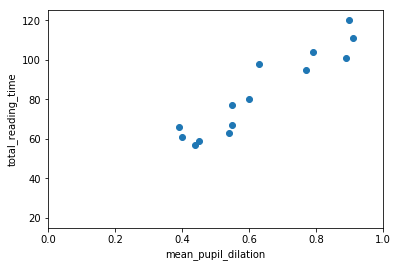

In [3]:
# So... first thing... let's plot mean_pupil_dilation and total_reading_time
# to see how they look like

# Gets the data
mean_pupil_dilation = np.array(data)[:, 1]
total_reading_time  = np.array(data)[:, 2]

# Let's show the data here too
print("mean_pupil_dilation", mean_pupil_dilation)
print("total_reading_time", total_reading_time)

# Creates the canvas
fig, axes = plt.subplots()

# Really plots the data
axes.plot(mean_pupil_dilation, total_reading_time, 'o')

# Puts names in the two axes (just for clearness)
axes.set_xlabel('mean_pupil_dilation')
axes.set_ylabel('total_reading_time')

pylab.xlim([0,1])
pylab.ylim([15, 125])

Training (part 1): Linear Regression
------------------------------------

### Formulating the Problem

In this first example, our goal is to find a function that cross all dots in the graph above. That is, this function should, for the values of `mean_pupil_dilation` that we know, have the values of `total_reading_time` in our dataset (or be the closest possible to them). We will also assume that this function is "linear". That is, we assume that it is possible to find a single straight line that works as a soluton for our problem.

With these assumptions in hand, we can now define this problem in a more formal way. A line can be always described by the function $y = Ax + b$, where the $A$ is referred to as the _slope_, and $b$ is normally called the _intercept_ (because it is where the line intercepts the $y$-axis when $x = 0$). In our case, the points that we already know about the line are going to help us to decide how this line is supposed to look like. That is:

$$
\begin{cases}
66  &= A \cdot 0.39  &+ b \\
61  &= A \cdot 0.4   &+ b \\
57  &= A \cdot 0.44  &+ b \\
59  &= A \cdot 0.45  &+ b \\
63  &= A \cdot 0.54  &+ b \\
67  &= A \cdot 0.55  &+ b \\
80  &= A \cdot 0.6   &+ b \\
77  &= A \cdot 0.55  &+ b \\
98  &= A \cdot 0.63  &+ b \\
95  &= A \cdot 0.77  &+ b \\
111 &= A \cdot 0.91  &+ b \\
104 &= A \cdot 0.79  &+ b \\
101 &= A \cdot 0.89  &+ b \\
120 &= A \cdot 0.9   &+ b \\
\end{cases}
$$

Of course, you don't need to be a genius to realize that this system of equations has no solution (that is, that no straight line will actually cross all the points in our graph). So, our goal is to find the _best_ line that gets the closest possible to all points we know. To indicate this in our equations, we insert a variable that stands for the "error".

$$
\begin{cases}
66  &= A \cdot 0.39  &+ b + \epsilon_1 \\
61  &= A \cdot 0.4   &+ b + \epsilon_2 \\
57  &= A \cdot 0.44  &+ b + \epsilon_3 \\
59  &= A \cdot 0.45  &+ b + \epsilon_4 \\
63  &= A \cdot 0.54  &+ b + \epsilon_5 \\
67  &= A \cdot 0.55  &+ b + \epsilon_6 \\
80  &= A \cdot 0.6   &+ b + \epsilon_7 \\
77  &= A \cdot 0.55  &+ b + \epsilon_8 \\
98  &= A \cdot 0.63  &+ b + \epsilon_9 \\
95  &= A \cdot 0.77  &+ b + \epsilon_{10} \\
111 &= A \cdot 0.91  &+ b + \epsilon_{11} \\
104 &= A \cdot 0.79  &+ b + \epsilon_{12} \\
101 &= A \cdot 0.89  &+ b + \epsilon_{13} \\
120 &= A \cdot 0.9   &+ b + \epsilon_{14} \\
\end{cases}
$$

Now... this notation is quite cluttered with lots of variables that repeat a lot. People who actually do this normally prefer to write this with matrices. The following equation means **exactly** the same:

$$
\begin{bmatrix}
66 \\ 61 \\ 57 \\ 59 \\ 63 \\ 67 \\ 80 \\ 77 \\ 98 \\ 95 \\ 111 \\ 104 \\ 101 \\ 120
\end{bmatrix}
= A
\begin{bmatrix}
0.39 \\ 0.4 \\ 0.44 \\ 0.45 \\ 0.54 \\ 0.55 \\ 0.6 \\ 0.55 \\ 0.63 \\ 0.77 \\ 0.91 \\ 0.79  \\ 0.89 \\ 0.9
\end{bmatrix}
+ b +
\begin{bmatrix}
\epsilon_{1} \\ \epsilon_{2} \\ \epsilon_{3}  \\ \epsilon_{4}  \\ \epsilon_{5}  \\ \epsilon_{6}  \\ \epsilon_{7} \\
\epsilon_{8} \\ \epsilon_{9} \\ \epsilon_{10} \\ \epsilon_{11} \\ \epsilon_{12} \\ \epsilon_{13} \\ \epsilon_{14} \\
\end{bmatrix}
$$

Finally... we often replace the vectors by bold letters and just write it as:

$$
\mathbf{y} = A\mathbf{x} + b + \boldsymbol{\epsilon}
$$

Our goal is, then, for each of the equations above, to find values of $A$ and $b$ such that the $\epsilon_i$ (i.e., the error) associated with that equation is the minimum possible.

### Evaluating a Regression solution

Now... there is a literally infinite number of possible lines, and we need to find a way to evaluate them, that is, decide if we like a certain line more than the others. For this, we probably should use the errors: lines that have big errors should be discarded, and lines that have low errors should be preferred. Unfortunately, there are several ways to "put together" all the $\epsilon_i$ denoting the errors associated with a given line. One way to "put together" all these $\epsilon_i$ could be summing them all:

$$
\text{Error over all equations: } \\E_{naïve} = \sum_i{\epsilon_i}
$$

However, you might have guessed by the word "naïve" there that this formula has problems. The problem with this formula the following: that, when some points are above and some points are below the line, the errors will "cancel" each other. For example:

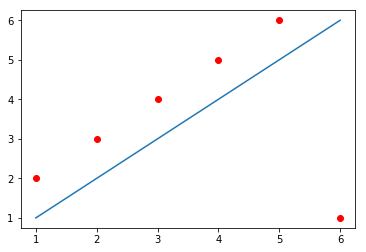

In [4]:
X = [1,2,3,4,5,6]
Y_line = np.array([1,2,3,4,5,6])
Y_dots = np.array([2,3,4,5,6,1])

plt.plot(X, Y_line)
plt.plot(X, Y_dots, 'ro')

One solution could be to simply use the absolute value of each $\epsilon$ when calculating the error value:

$$
\text{Error over all equations: } \\E_{L_1} = \sum_i{\mid\epsilon_i\mid} = \|\boldsymbol{\epsilon}\|_1
$$

This is a commonly used formula for evaluating the quality of a regression curve. Summing the magnitude of each $\epsilon$ this way is referred to as calculating the $L_1$ norm of the $\epsilon$ vector.

Unfortunately, the absolute-value function is not differentiable everywhere in its domain. That is, the derivative of this function is not defined at the point when $x = 0$. This is not a terrible problem, but we are going to need differentiation later, and a great alternative function that doesn't have this problem is the $L_2$ norm:

$$
\text{Error over all equations: } \\E_{L_2} = \sum_i{{\epsilon_i}^2} = \|\boldsymbol{\epsilon}\|_2 \\
\text{(}\textit{i.e.}\text{, the Sum of Squared Errors)}
$$

In [5]:
# (Following the example immediately above)

# Calculating the error in a very naive way
print("Error naive: ", np.sum(Y_dots - Y_line))

# Calculating the error using the absolute value of the epsilons:
print("Error L1:    ", np.sum(np.absolute(Y_dots - Y_line)))

# Calculating the error using the absolute value of the epsilons:
print("Error L2:    ", np.sum((Y_dots - Y_line)**2))

Error naive:  0
Error L1:     10
Error L2:     30


This function is **the** usual choice for evaluating the Regression line. It is differentiable everywhere, but is not so robust to outliers as the $L_1$ norm.

Motivating Gradient Descent (a method to find the _best_ line)
---------------------------------------------------

In the sections above, we have defined what we want to get: a good line -- hopefully, the best one -- that (almost) crosses all the points in our dataset. We have also understood how to decide if a line is good or not, based on the errors between the value predicted by the line and the value that appears in our data.

The images below show several possible lines, with slopes 10, 30, 50, 100 and 200. The last graph shows the _Sum of Squared Errors_ (the $L_2$ norm of the error vector $\epsilon$) for each of the lines:

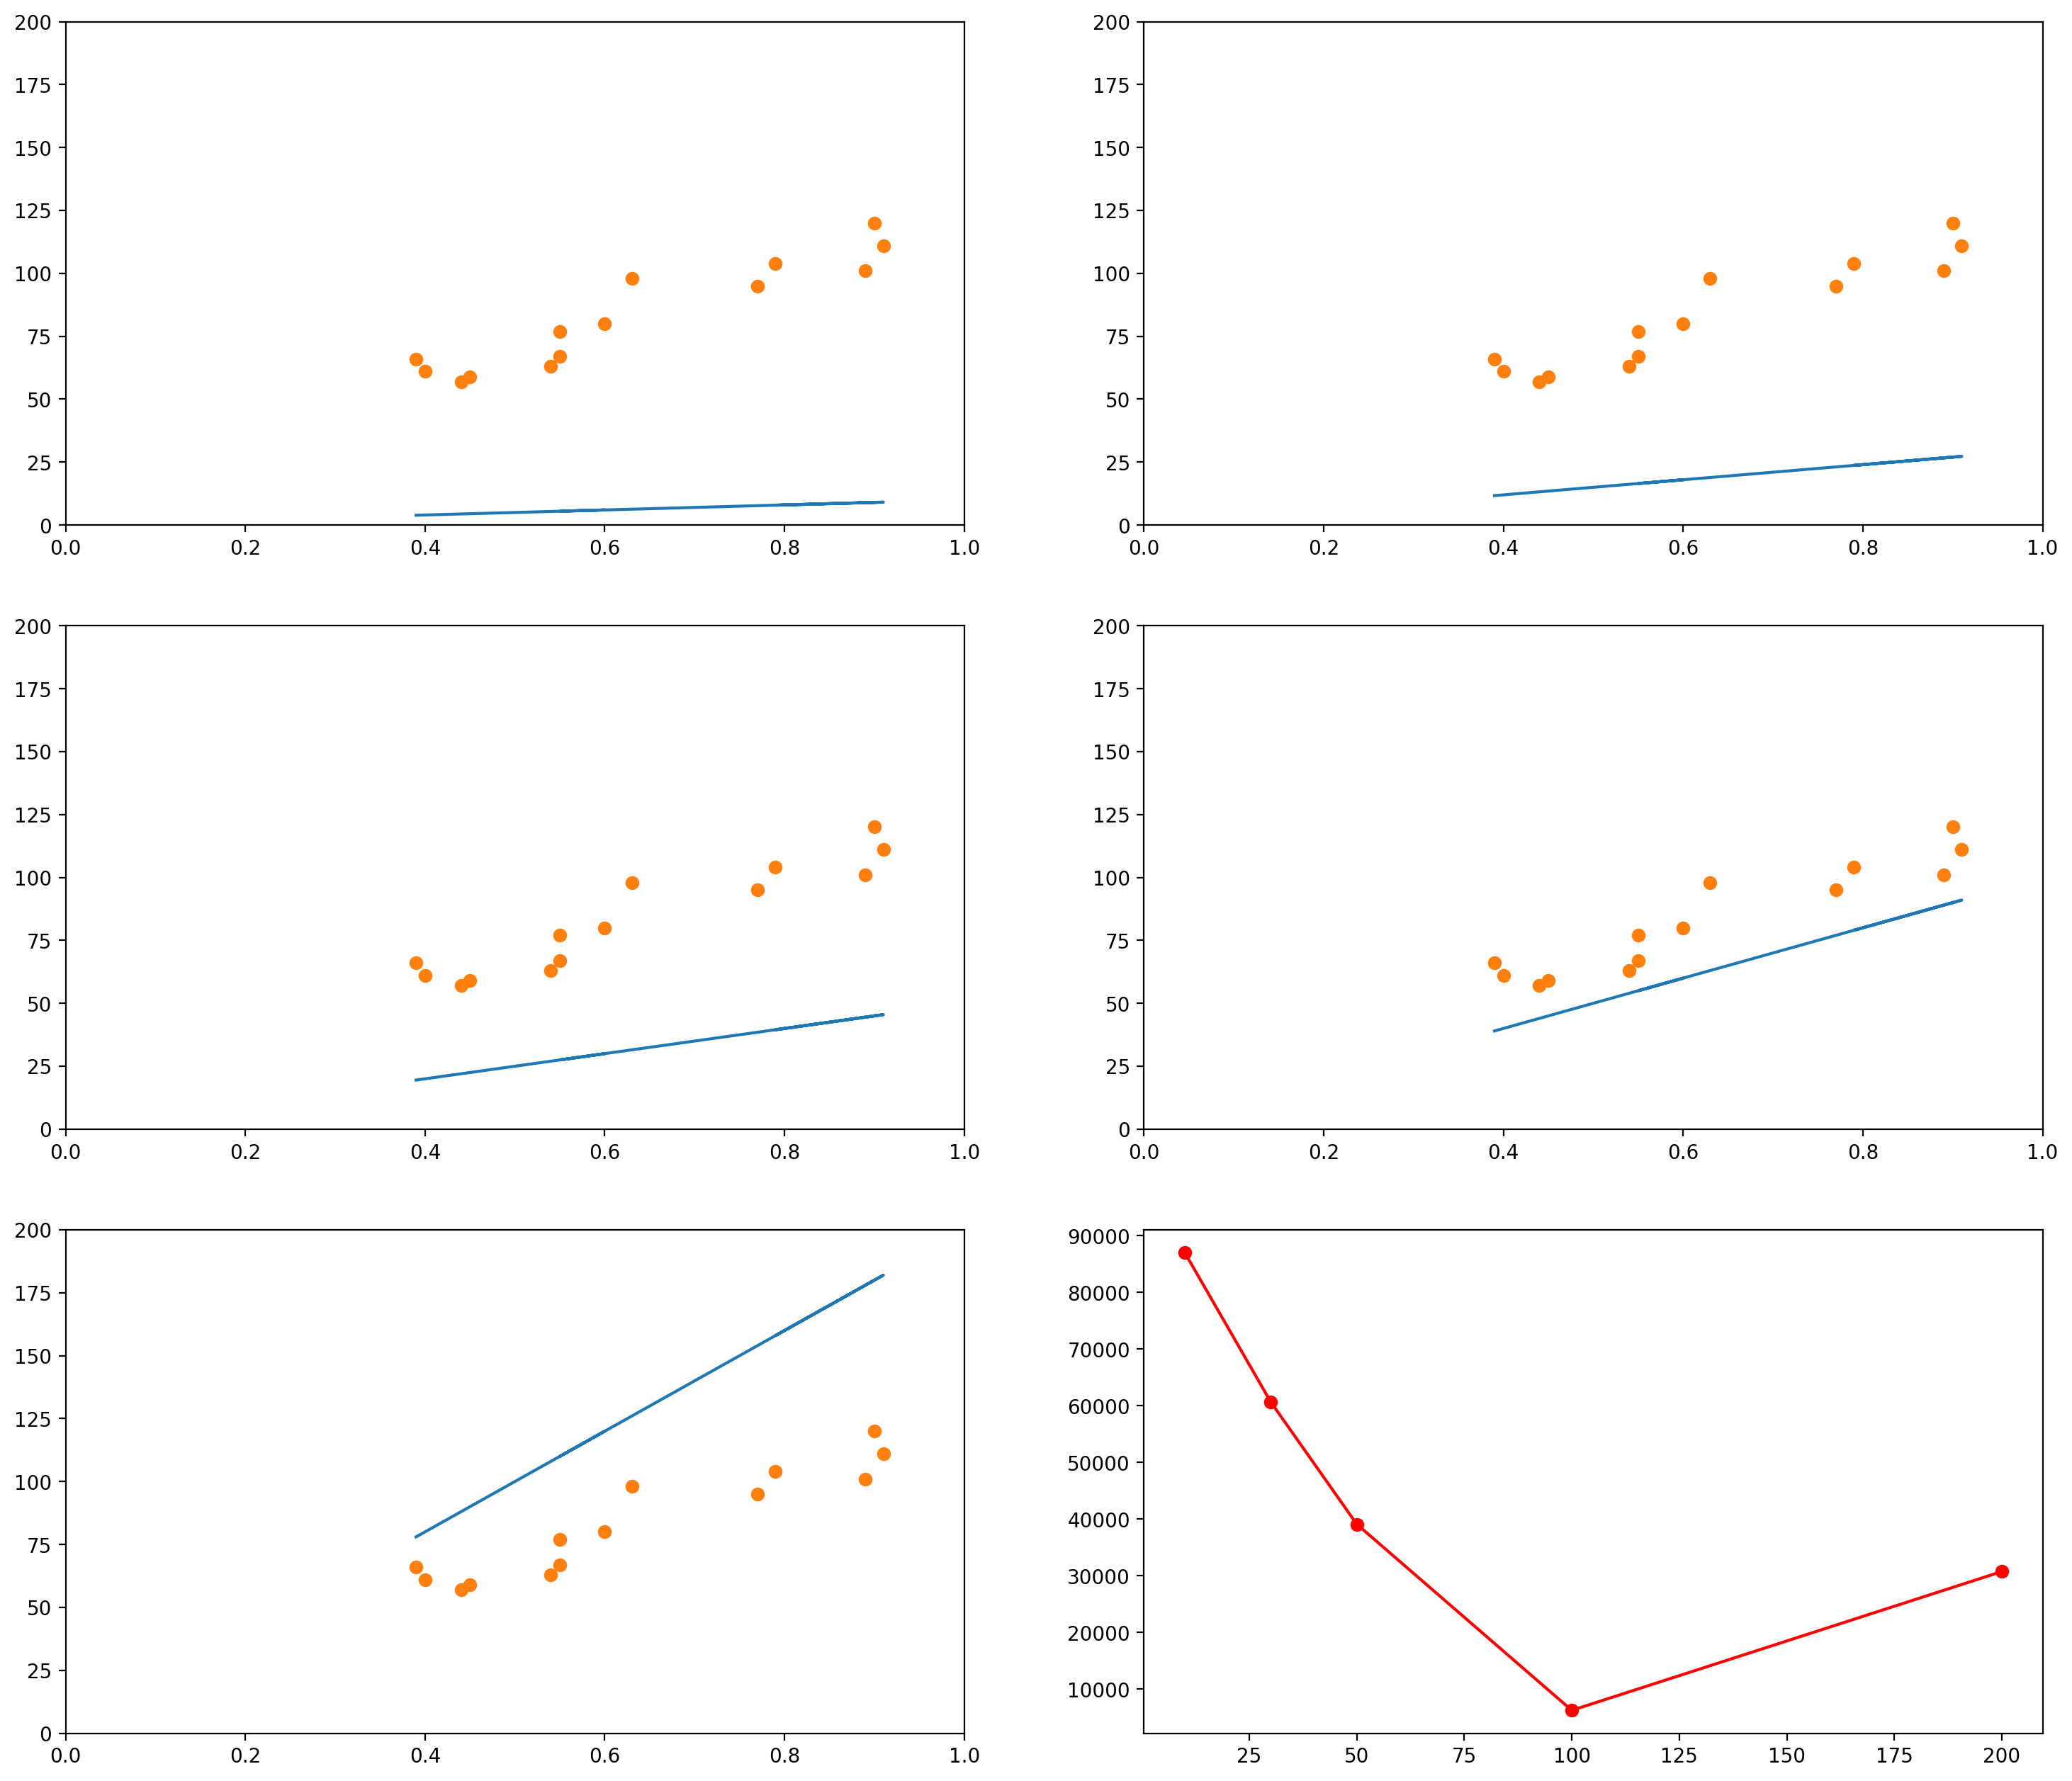

In [6]:
# This is the original data
data_x = mean_pupil_dilation
data_y = total_reading_time

# Let's create some possible lines
plot_x1 = mean_pupil_dilation
plot_y1 = 10*plot_x1 + 0

plot_x2 = mean_pupil_dilation
plot_y2 = 30*plot_x2 + 0

plot_x3 = mean_pupil_dilation
plot_y3 = 50*plot_x3 + 0

plot_x4 = mean_pupil_dilation
plot_y4 = 100*plot_x4 + 0

plot_x5 = mean_pupil_dilation
plot_y5 = 200*plot_x5 + 0

# Now let's plot these lines, along with the data
def plot_line_and_dots(line, dots, lims):
    line_x, line_y = line
    dots_x, dots_y = dots
    xlim, ylim = lims
    plt.plot(line_x, line_y)
    plt.plot(dots_x, dots_y, 'o')
    plt.xlim(xlim)
    plt.ylim(ylim)

plt.figure(figsize=(18, 16), dpi= 200)

plt.subplot(3,2,1)
plot_line_and_dots([plot_x1, plot_y1], [data_x, data_y], [[0,1],[0, 200]])

plt.subplot(3,2,2)
plot_line_and_dots([plot_x2, plot_y2], [data_x, data_y], [[0,1],[0, 200]])

plt.subplot(3,2,3)
plot_line_and_dots([plot_x3, plot_y3], [data_x, data_y], [[0,1],[0, 200]])

plt.subplot(3,2,4)
plot_line_and_dots([plot_x4, plot_y4], [data_x, data_y], [[0,1],[0, 200]])

plt.subplot(3,2,5)
plot_line_and_dots([plot_x5, plot_y5], [data_x, data_y], [[0,1],[0, 200]])

# Finally, in the last plot, let's look at the error between the 

squared_errors1 = (plot_y1 - total_reading_time)**2
squared_errors2 = (plot_y2 - total_reading_time)**2
squared_errors3 = (plot_y3 - total_reading_time)**2
squared_errors4 = (plot_y4 - total_reading_time)**2
squared_errors5 = (plot_y5 - total_reading_time)**2

plt.subplot(3,2,6)
plt.plot([10, 30, 50, 100, 200],
         [sum(squared_errors1),
          sum(squared_errors2),
          sum(squared_errors3),
          sum(squared_errors4),
          sum(squared_errors5)], '-ro')


As you can see, when the slope is 10, the $L_2$ norm of the error vector is very high. As the slope keeps increasing, the error goes on decreasing, until a certain moment, when it increases again.

We could plot the Sum of Squared errors of many many of these lines, and we would get a function that looks like the following:

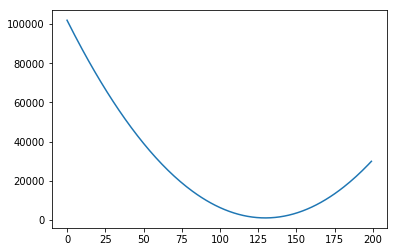

In [7]:
# Initialize an empty list
error_l2_norms = []

for i in range(200):
    # Gets the y values of the line, given the slope i
    plot_y1 = i*plot_x1 + 0
    # Calculates the sum of squared errors for all the data points we have
    sum_squared_errors = sum((plot_y1 - total_reading_time)**2)
    # Inserts the sum in our list
    error_l2_norms.append(sum_squared_errors)

# Now we plot the 200 elements of the list, along with the sum of squared errors
plt.plot(range(200), error_l2_norms)

Notice that so far we only moved the _slope_. We could do the same with the _intercept_. For example, let's say we fixed our slope in 75. Then we could generate graphs with intercepts, say, 0, 20, 40, 60, 80:

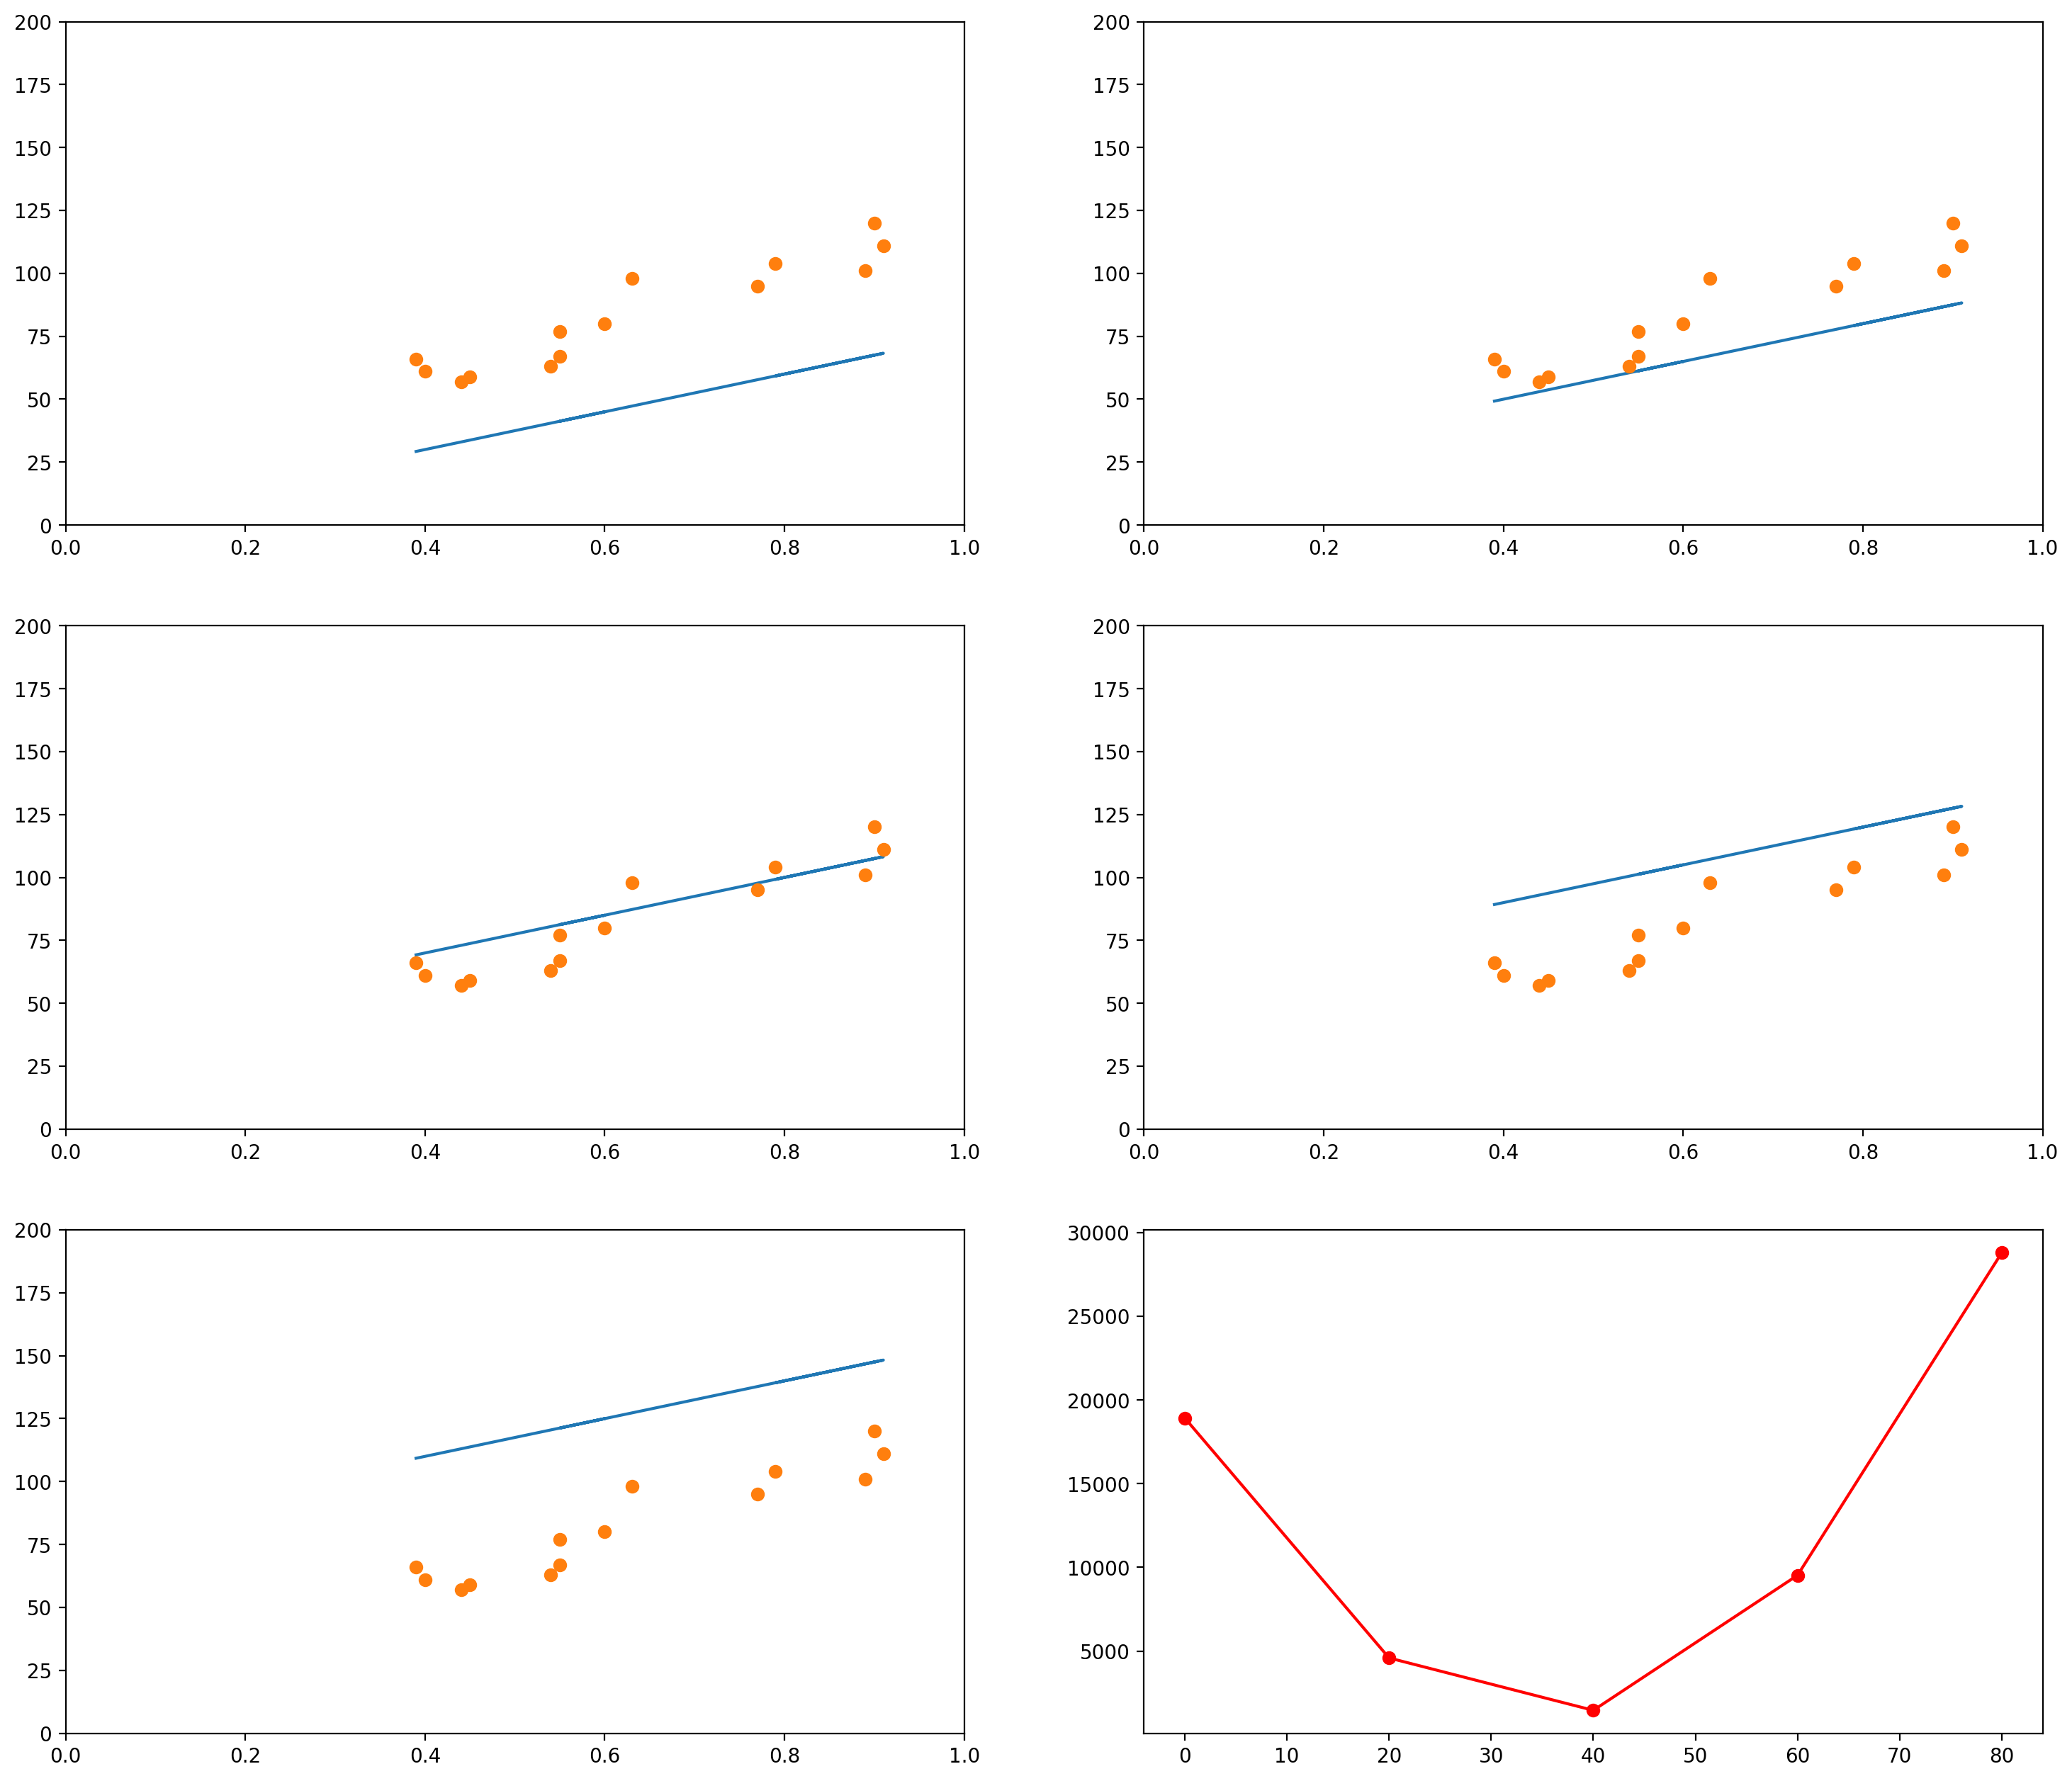

In [8]:
# This is the original data
data_x = mean_pupil_dilation
data_y = total_reading_time
slope = 75

# Let's create some possible lines
plot_x1 = mean_pupil_dilation
plot_y1 = slope*plot_x1 + 0

plot_x2 = mean_pupil_dilation
plot_y2 = slope*plot_x2 + 20

plot_x3 = mean_pupil_dilation
plot_y3 = slope*plot_x3 + 40

plot_x4 = mean_pupil_dilation
plot_y4 = slope*plot_x4 + 60

plot_x5 = mean_pupil_dilation
plot_y5 = slope*plot_x5 + 80

plt.figure(figsize=(18, 16), dpi= 200)

plt.subplot(3,2,1)
plot_line_and_dots([plot_x1, plot_y1], [data_x, data_y], [[0,1],[0, 200]])

plt.subplot(3,2,2)
plot_line_and_dots([plot_x2, plot_y2], [data_x, data_y], [[0,1],[0, 200]])

plt.subplot(3,2,3)
plot_line_and_dots([plot_x3, plot_y3], [data_x, data_y], [[0,1],[0, 200]])

plt.subplot(3,2,4)
plot_line_and_dots([plot_x4, plot_y4], [data_x, data_y], [[0,1],[0, 200]])

plt.subplot(3,2,5)
plot_line_and_dots([plot_x5, plot_y5], [data_x, data_y], [[0,1],[0, 200]])

# Finally, in the last plot, let's look at the error between the 

squared_errors1 = (plot_y1 - total_reading_time)**2
squared_errors2 = (plot_y2 - total_reading_time)**2
squared_errors3 = (plot_y3 - total_reading_time)**2
squared_errors4 = (plot_y4 - total_reading_time)**2
squared_errors5 = (plot_y5 - total_reading_time)**2

plt.subplot(3,2,6)
plt.plot([0, 20, 40, 60, 80],
         [sum(squared_errors1),
          sum(squared_errors2),
          sum(squared_errors3),
          sum(squared_errors4),
          sum(squared_errors5)], '-ro')


Of course, again, we could plot the errors of curves for many other values of intercept:

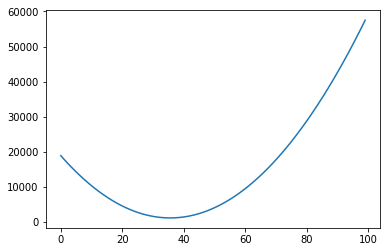

In [9]:
# Initialize an empty list
error_l2_norms = []
slope = 75

for i in range(100):
    # Gets the y values of the line, given the slope i
    plot_y1 = slope*plot_x1 + i
    # Calculates the sum of squared errors for all the data points we have
    sum_squared_errors = sum((plot_y1 - total_reading_time)**2)
    # Inserts the sum in our list
    error_l2_norms.append(sum_squared_errors)

plt.plot(range(100), error_l2_norms)

In each of the graphs above, we fixed a value for one of the variables (either the intercept or the slope) and iterated through many possible values of the other variable. It is important to notice that, as one of the variables change, the curve for the other variable also changes. In the example above, we had chosen a slope of 75. The example below shows what happens when we use a slope of 200. The graph to the left has an intercept of 0; the graph to the right shows how the error change as the intercept increases from 0 to 100.

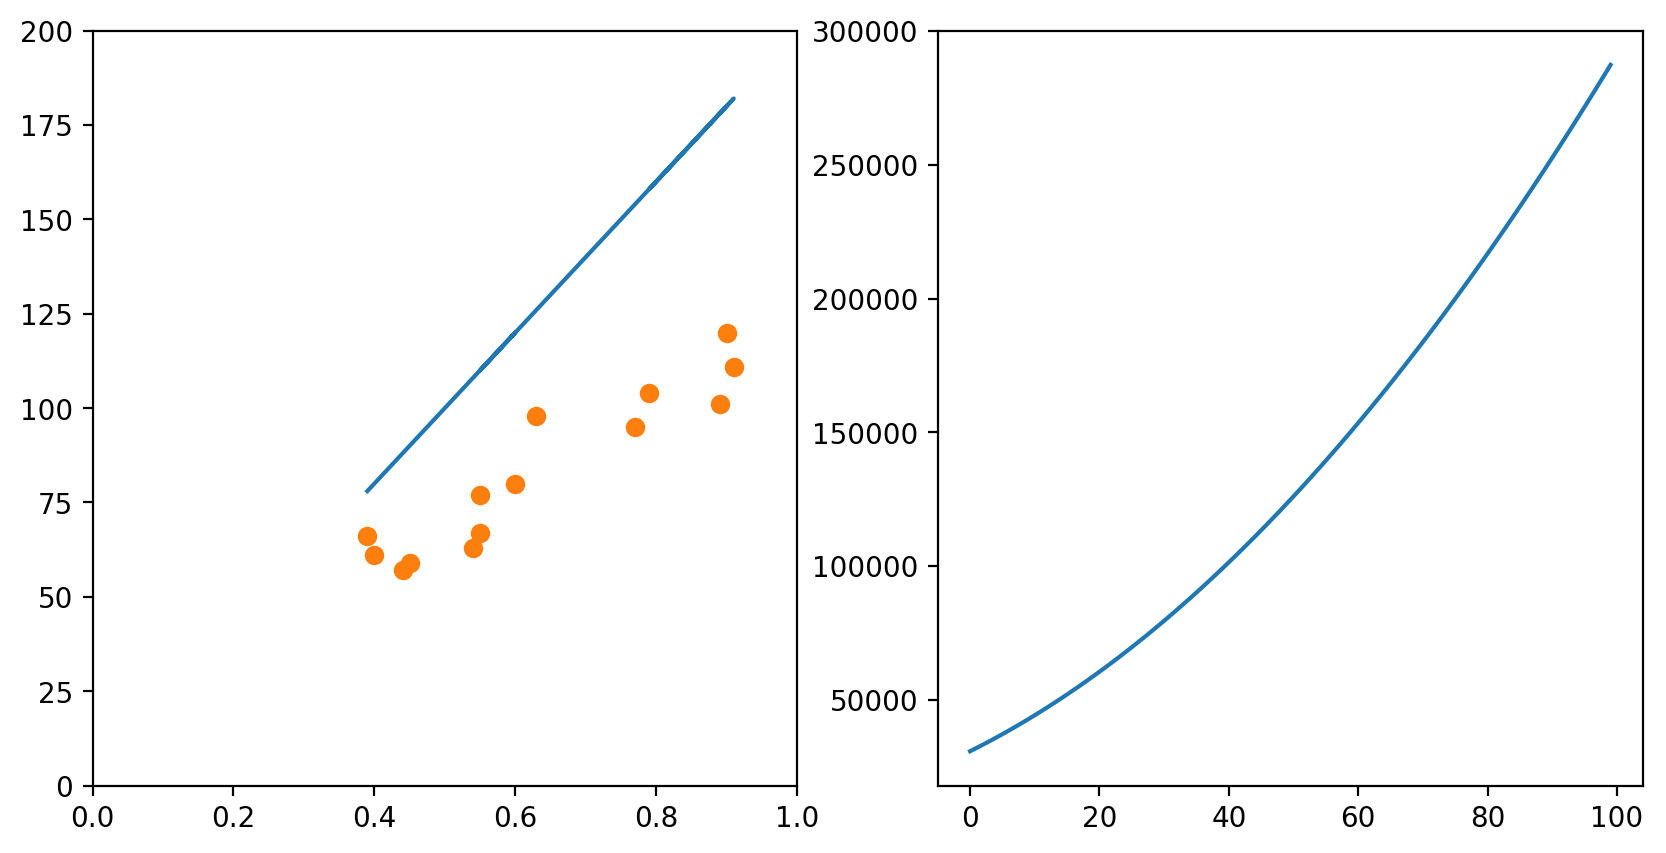

In [10]:
slope = 200

# Change the default size of the plotting
plt.figure(figsize=(10, 5), dpi= 200)

plot_x = mean_pupil_dilation
plot_y = slope*plot_x5 + 0
plt.subplot(1,2,1)
plot_line_and_dots([plot_x, plot_y], [data_x, data_y], [[0,1],[0, 200]])

# Initialize an empty list
error_l2_norms = []

for i in range(100):
    # Gets the y values of the line, given the slope i
    plot_y1 = slope*plot_x1 + i
    # Calculates the sum of squared errors for all the data points we have
    sum_squared_errors = sum((plot_y1 - total_reading_time)**2)
    # Inserts the sum in our list
    error_l2_norms.append(sum_squared_errors)

# Now we plot the 100 elements of the list, along with the sum of squared errors
plt.subplot(1,2,2)
plt.plot(range(100), error_l2_norms)

Of course, if one had time, one could try all possible combinations of slope and intercept and choose the best one. This would generate a surface in the 3D space:

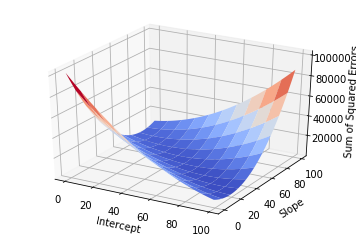

In [11]:
# Initialize an empty list
error_l2_norms = np.zeros([100, 100])

for i in range(100):
    for slope in range(100):
        # Gets the y values of the line, given the slope i
        plot_y1 = slope*plot_x1 + i
        # Calculates the sum of squared errors for all the data points we have
        sum_squared_errors = sum((plot_y1 - total_reading_time)**2)
        # Inserts the sum in our list
        error_l2_norms[i, slope] = sum_squared_errors

X = np.arange(0, 100, 1)
Y = np.arange(0, 100, 1)
X, Y = np.meshgrid(X, Y)
Z = error_l2_norms

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_xlabel('Intercept')
ax.set_ylabel('Slope')
ax.set_zlabel('Sum of Squared Errors')
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, rstride=10, cstride=10)

But this approach would be too computationally intensive, and if you had more variables it would probably take too long.

Enter Gradient Descent
---------------------

To solve this problem in an easy way, we use Gradient Descent. We will first understand the intuition of Gradient Descent, and then understand how the maths work.

Using our example above, let's focus on what Gradient Descent would do if we had the two variables _Intercept_ and _Slope_ and wanted to find the best configuration of _Intercept_ and _Slope_ (i.e., the configuration for which the error is minimum). Gradient Descent would start with any random configuration. Then, given this configuration, it would ask:

 * In which direction (and how 'strongly') do I need to change my _Intercept_ so that my error would increase?"

In more fancy mathy terms, it would calculate the _derivative_ of the error function (the surface plotted above) with respect to the variable _Intercept_. It would then keep this "direction" in a variable.

At the same time, it would also ask:

 * In which direction (and how 'strongly') do I need to change my _Slope_ so that my error would increase?"
    
Again, this is the same as calculating the _derivative_ of the error function with respect to the _Slope_. It would then also store this "direction" in a variable.

Finally, it would take the current _Intercept_ and _Slope_ and update them using the values it just calculated: since it calculated the direction in which the error would _increase_, it updates the two variables in the opposite direction).

### More formally

Now we are ready to understand the formal notation for the algorithm. Remember that our error function is the _Sum of Squared Errors_, also referred to as the $L_2$-norm of the error vector $\boldsymbol{\epsilon}$, and that this $L_2$-norm is normally written as $\| \cdot \|_2$. That is, the $L_2$-norm of $\boldsymbol{\epsilon}$ is normally written $\| \boldsymbol{\epsilon} \|_2$.

Proceeding, we want to represent the _derivative_ of the error function with respect to the variables _Intercept_ (which we were referring to as $A$) and _Slope_ (which we were referring to as $b$). These derivatives are normally written as

$$
\frac{\partial \|\boldsymbol{\epsilon}\|_2}{\partial A}
\text{ and }
\frac{\partial \|\boldsymbol{\epsilon}\|_2}{\partial b}
$$

Notice that the error function $\| \boldsymbol{\epsilon} \|_2$ depends exclusively on these two variables. This leads us to the concept of "Gradient". The Gradient of the error function is a vector containing the derivative of each of the variables on which it depends. Since $\|\boldsymbol{\epsilon}\|_2$ depends only on $A$ and $b$, the Gradient of $\|\boldsymbol{\epsilon}\|_2$ (we represent it by $\nabla \|\boldsymbol{\epsilon}\|_2$) is the following vector:

$$ \nabla \|\boldsymbol{\epsilon}\|_2 = 
\Big(\frac{\partial \|\boldsymbol{\epsilon}\|_2}{\partial A}
,
\frac{\partial \|\boldsymbol{\epsilon}\|_2}{\partial b}\Big)
$$

After calculating the value of the Gradient, we can just update the value of $A$ and $b$ accordingly:

$$
A \leftarrow A - \lambda \cdot \frac{\partial \|\boldsymbol{\epsilon}\|_2}{\partial A}
\\
b \leftarrow b - \lambda \cdot \frac{\partial \|\boldsymbol{\epsilon}\|_2}{\partial b}
$$

The $\lambda$ there is the "learning rate": it might make sense to make smaller or bigger jumps if you know you are too close or too far away from the local minimum.

#### Problems with Gradient Descent

The Gradient Descent procedure will normally help us find a so-called "local minimum": a solution that is better than all solutions nearby. Consider, however, the graph below:

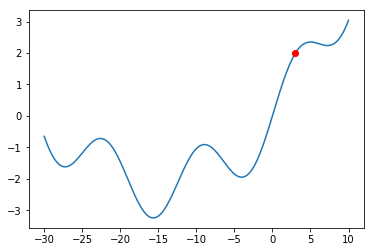

In [12]:
# Defines (x,y) coordinates for many points for the curve
x = np.linspace(-30, 10, 200)
y = np.sin(0.5*x) + .3*x + .01*x**2

# Plots the (x,y) coordinates defined above
plt.plot(x, y)

# Plots a red dot at the point x=3
plt.plot([3], [np.sin(0.5*3) + .3*3 + .01*3**2], 'ro')

**What would happen if we were at the red dot and used Gradient Descent to find a solution?**

Even though there might be shortcomings to Gradient Descent, this is _the method_ used in a lot of Machine Learning problems, and this is in part why we took a look at it. The problem of Linear Regression is very often a "convex optimization problem", which means it doesn't have those local minima above. _(they will appear, however, soon, in other problems, so it is useful to discuss them here)_

### Going beyond 1-dimensional inputs

Of course, the same concepts can be applied when you have more than one variables and you would like to predict the value of another variable. For example, let's say we now had both the `mean_pupil_dilation` and the number of fixations (`num_fixations` below) and we wanted to predict the `total_reading_time`. In the code below, we will put these values in convenient data structures:

In [13]:
# This was how we had taken the variables separately
mean_pupil_dilation = np.array(data)[:, 1]
total_reading_time  = np.array(data)[:, 2]
num_fixations = np.array(data)[:, 3]

# We can use the `zip()` function to put them all together again
# `zip()` returns a generator... so we use `list()` to transform it into a list
dilation_fixations = list(zip(mean_pupil_dilation, num_fixations))
print("mean_pupil_dilation", mean_pupil_dilation)
print("--")
print("num_fixations", num_fixations)
print("--")
print("dilation_fixations", dilation_fixations)

mean_pupil_dilation [0.9  0.89 0.79 0.91 0.77 0.63 0.55 0.6  0.55 0.54 0.45 0.44 0.4  0.39]
--
num_fixations [20. 18. 24. 19. 20. 22. 30. 23. 56. 64. 42. 43. 51. 40.]
--
dilation_fixations [(0.9, 20.0), (0.89, 18.0), (0.79, 24.0), (0.91, 19.0), (0.77, 20.0), (0.63, 22.0), (0.55, 30.0), (0.6, 23.0), (0.55, 56.0), (0.54, 64.0), (0.45, 42.0), (0.44, 43.0), (0.4, 51.0), (0.39, 40.0)]


Let's also plot the data in 3D, to get a notion of how it looks like (it is the same data... even though it might not seem the same at a first glance).

Text(0.5,0,'Number of Fixations')

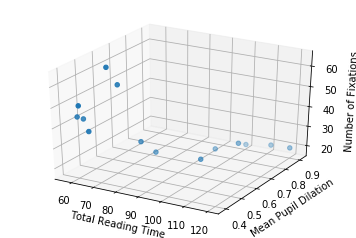

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(total_reading_time, mean_pupil_dilation, num_fixations)
ax.set_xlabel('Total Reading Time')
ax.set_ylabel('Mean Pupil Dilation')
ax.set_zlabel('Number of Fixations')

So now, with two input dimensions and one output dimension, we don't only have a line, characterized by a single _slope_ and a single _intercept_, but a plane, characterized by 3 variables: one _intercept_ and two _coefficients_.

In the sections above, our line equation looked like this:

$$
\mathbf{y} = A\mathbf{x} + b + \boldsymbol{\epsilon} \\
$$

Where $A$ was a scalar (a number) and $\mathbf{x}$ was a column vector. That is, the equation looked like this:

$$
\begin{bmatrix}
y_1 \\ y_2 \\ \vdots \\ y_n
\end{bmatrix} = A 
                \begin{bmatrix}
                x_1 \\
                x_2 \\
                \vdots \\
                x_n
                \end{bmatrix}
                + b +
                \begin{bmatrix}
                \epsilon_1 \\
                \epsilon_2 \\
                \vdots \\
                \epsilon_n
                \end{bmatrix}
$$

Now, instead of having only one $A$, we have two values: $A_1$ and $A_2$. The first value, $A_1$, should be multiplied by the pupil dilation; and the second value, $A_2$, should be multiplied by the number of fixations.

To make this equation function exactly in the same way as before, we can write it like this:

$$
\begin{bmatrix}
y_1 \\ y_2 \\ \vdots \\ y_n
\end{bmatrix} = \begin{bmatrix}A_1 & A_2 \end{bmatrix}
                \begin{bmatrix}
                x_{11} & x_{12} \\
                x_{21} & x_{22} \\
                \vdots & \vdots \\
                x_{n1} & x_{n2}
                \end{bmatrix}^{\top}
                + b +
                \begin{bmatrix}
                \epsilon_1 \\
                \epsilon_2 \\
                \vdots \\
                \epsilon_n
                \end{bmatrix}
$$

Of course, if you had more variables, you could just add more columns to the $A$ matrix and to the $\mathbf{x}$ matrix. For example, if you had $m$ variables, you would have:

$$
\begin{bmatrix}
y_1 \\ y_2 \\ \vdots \\ y_n
\end{bmatrix} = \begin{bmatrix}A_1 & A_2 & \cdots & A_m \end{bmatrix}
                \begin{bmatrix}
                x_{11} & x_{12} & \cdots & x_{1m} \\
                x_{21} & x_{22} & \cdots & x_{2m} \\
                \vdots & \vdots & \ddots & \vdots \\
                x_{n1} & x_{n2} & \cdots & x_{nm}
                \end{bmatrix}^{\top}
                + b +
                \begin{bmatrix}
                \epsilon_1 \\
                \epsilon_2 \\
                \vdots \\
                \epsilon_n
                \end{bmatrix}
$$

So, putting the numbers in place, remember that we had the following two vectors:

 * Pupil dilations: $\begin{bmatrix}0.9 & 0.89 & 0.79 & 0.91 & 0.77 & 0.63 & 0.55 & 0.6 & 0.55 & 0.54 & 0.45 & 0.44 & 0.4 & 0.39\end{bmatrix}$
 * Number of fixations: $\begin{bmatrix}20  & 18   & 24   & 19   & 20   & 22   & 30   & 23  & 56   & 64   & 42   & 43   & 51  & 40 \end{bmatrix}$

Then our equation would become:

$$
\begin{bmatrix}
66 \\ 61 \\ 57 \\ 59 \\ 63 \\ 67 \\ 80 \\ 77 \\ 98 \\ 95 \\ 111 \\ 104 \\ 101 \\ 120
\end{bmatrix} = \begin{bmatrix} A_1 & A_2 \end{bmatrix} 
                \begin{bmatrix}
                0.9   & 20 \\
                0.89  & 18 \\
                0.79  & 24 \\
                0.91  & 19 \\
                0.77  & 20 \\
                0.63  & 22 \\
                0.55  & 30 \\
                0.6   & 23 \\
                0.55  & 56 \\
                0.54  & 64 \\
                0.45  & 42 \\
                0.44  & 43 \\
                0.4   & 51 \\
                0.39  & 40 \\
                \end{bmatrix}^{\top}
              + b + \boldsymbol{\epsilon}
$$

Just to make it clear, that "$\top$" over the matrix containing our numbers indicates that the matrix was transposed. You could rewrite the equation as:

$$
\begin{bmatrix}
66 \\ 61 \\ 57 \\ 59 \\ 63 \\ 67 \\ 80 \\ 77 \\ 98 \\ 95 \\ 111 \\ 104 \\ 101 \\ 120
\end{bmatrix} = \\ \begin{bmatrix} A_1 & A_2 \end{bmatrix}
            \begin{bmatrix}
             0.9 & 0.89 & 0.79 & 0.91 & 0.77 & 0.63 & 0.55 & 0.6 & 0.55 & 0.54 & 0.45 & 0.44 & 0.4 & 0.39 \\
             20  & 18   & 24   & 19   & 20   & 22   & 30   & 23  & 56   & 64   & 42   & 43   & 51  & 40
             \end{bmatrix} + b + \boldsymbol{\epsilon}
$$

Then our gradient descent does exactly the same. We first calculate the gradient of the error function, which now is composed by three elements:

$$ \nabla \|\boldsymbol{\epsilon}\|_2 = 
\Big(\frac{\partial \|\boldsymbol{\epsilon}\|_2}{\partial A_1}
,
\frac{\partial \|\boldsymbol{\epsilon}\|_2}{\partial A_2}
,
\frac{\partial \|\boldsymbol{\epsilon}\|_2}{\partial b}\Big)
$$

And update our variables in the opposite direction:

$$
A_1 \leftarrow A_1 - \lambda \cdot \frac{\partial \|\boldsymbol{\epsilon}\|_2}{\partial A_1}
\\
A_2 \leftarrow A_2 - \lambda \cdot \frac{\partial \|\boldsymbol{\epsilon}\|_2}{\partial A_2}
\\
b \leftarrow b - \lambda \cdot \frac{\partial \|\boldsymbol{\epsilon}\|_2}{\partial b}
$$

Or, more generally, if we had $m$ variables,

$$ \nabla \|\boldsymbol{\epsilon}\|_2 = 
\Big(\frac{\partial \|\boldsymbol{\epsilon}\|_2}{\partial A_1}
,
\frac{\partial \|\boldsymbol{\epsilon}\|_2}{\partial A_2}
,
\dots
,
\frac{\partial \|\boldsymbol{\epsilon}\|_2}{\partial A_m}
,
\frac{\partial \|\boldsymbol{\epsilon}\|_2}{\partial b}\Big)
$$

and updates:

$$
A_1 \leftarrow A_1 - \lambda \cdot \frac{\partial \|\boldsymbol{\epsilon}\|_2}{\partial A_1}
\\
A_2 \leftarrow A_2 - \lambda \cdot \frac{\partial \|\boldsymbol{\epsilon}\|_2}{\partial A_2}
\\
\dots
\\
A_m \leftarrow A_m - \lambda \cdot \frac{\partial \|\boldsymbol{\epsilon}\|_2}{\partial A_m}
\\
b \leftarrow b - \lambda \cdot \frac{\partial \|\boldsymbol{\epsilon}\|_2}{\partial b}
$$

### Ok... but how do I do Regression in Python? (using sklearn)

We will use the `sklearn` library in Python to calculate the Linear Regression for us. It receives the input data (the `mean_pupil_dilation` vector) and the expected output data (the `total_reading_time` vector). Then it updates its `coef_` and `intercept_` variables with the slope and intercept, respectively.

_(Importantly, because the problem of Linear Regression is quite simple, it is likely not using Gradient Descent in sklearn)_

In [15]:
# Adapted from http://scikit-learn.org/stable/modules/linear_model.html

# from sklearn import linear_model

# LinearRegression() returns an object that we will use to do regression
reg = linear_model.LinearRegression()

# Prepare our data
X = np.expand_dims(mean_pupil_dilation, axis=1)
Y = total_reading_time

# And print it to the screen
print("X: ", X)
print("Y: ", Y)

# Now we use the `reg` object to learn the best line
reg.fit(X, Y)

# And show, as output, the slope and intercept of the learnt line
reg.coef_, reg.intercept_

X:  [[0.9 ]
 [0.89]
 [0.79]
 [0.91]
 [0.77]
 [0.63]
 [0.55]
 [0.6 ]
 [0.55]
 [0.54]
 [0.45]
 [0.44]
 [0.4 ]
 [0.39]]
Y:  [120. 101. 104. 111.  95.  98.  77.  80.  67.  63.  59.  57.  61.  66.]


/Users/johncbgamboa/venv/compling/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


(array([106.68664055]), 15.649335484366603)

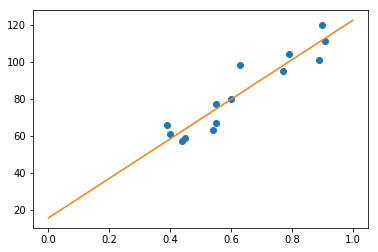

In [16]:
# Now we will plot the data
# Define a line using the slope and intercept that we got from the previous snippet
x = np.linspace(0, 1, 100)
y = reg.coef_ * x + reg.intercept_

# Creates the canvas
fig, axes = plt.subplots()

# Plots the dots
axes.plot(mean_pupil_dilation, total_reading_time, 'o')

# Plots the line
axes.plot(x, y)

Training (part 2): Logistic Regression
--------------------------------------

(This section is very much inspired by [Andrew Ng's awesome Machine Learning videos](https://www.youtube.com/watch?v=-la3q9d7AKQ).

So far, our model has been exclusively linear: it fits a line (or a plane) into the data.

However, sometimes our data might be better fit as a choice between two values. For example, when a bank wants to decide if a client is going to pay back a loan, or a spam filter wants to decide if an email is a spam or not. In these cases, the program needs to make a decision and it doesn't make sense to choose a value "in between".

To make our example useful for this binary classification, I changed our data (although it is still the exact same data) so that we talk about "detecting spam". Let's plot the variables `spam` against the `concordance_errors` data, along with the best line that fits both values:

In [10]:
# Generates some fictitious data

columns = ["spam",
           "concordance_errors",
           "correct_punctuations"]

spam_data = [
    [True,  120, 20],
    [True,  101, 18],
    [True,  104, 24],
    [True,  111, 19],
    [True,   95, 20],
    [True,   98, 22],
    [True,   77, 30],
    [False,  80, 23],
    [False,  67, 56],
    [False,  63, 64],
    [False,  59, 42],
    [False,  57, 43],
    [False,  61, 51],
    [False,  66, 40]
]

spam_test_data = [
    [True, 102, 17],
    [True, 101, 12],
    [False, 60, 52],
    [False, 54, 44]
]

is_spam [1 1 1 1 1 1 1 0 0 0 0 0 0 0]
concordance_errors [120 101 104 111  95  98  77  80  67  63  59  57  61  66]


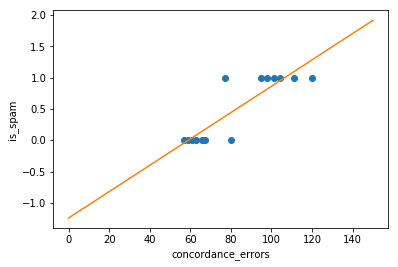

In [117]:
# Gets the data
is_spam = np.array(spam_data)[:, 0]
concordance_errors = np.array(spam_data)[:, 1]

# Let's show the data here too
print("is_spam", is_spam)
print("concordance_errors", concordance_errors)

# Creates the canvas
fig, axes = plt.subplots()

# Really plots the data
axes.plot(concordance_errors, is_spam, 'o')

# Puts names in the two axes (just for clearness)
axes.set_xlabel('concordance_errors')
axes.set_ylabel('is_spam')

reg = linear_model.LinearRegression()

# Prepare our data
X = np.expand_dims(concordance_errors, axis=1)
Y = is_spam

# Now we use the `reg` object to learn the best line
reg.fit(X, Y)

# Now we will plot the data
# Define a line using the slope and intercept that we got from the previous snippet
x = np.linspace(0, 150, 100)
y = reg.coef_ * x + reg.intercept_

# Plots the line
axes.plot(x, y)

In this case, it might seem that Linear Regression is doing something senseful: we could convert any value smaller than $0.5$ into `False` and whatever value bigger than $0.5$ into `True`. But consider what would happen if there were other data points who took much longer to read:

In [119]:
changed_ccr = np.append(concordance_errors,
                        [1270, 1265, 1250, 1260, 1300, 1298, 1280, 1290, 1279])
changed_spam = np.append(is_spam, [1,1,1,1,1,1,1,1,1])

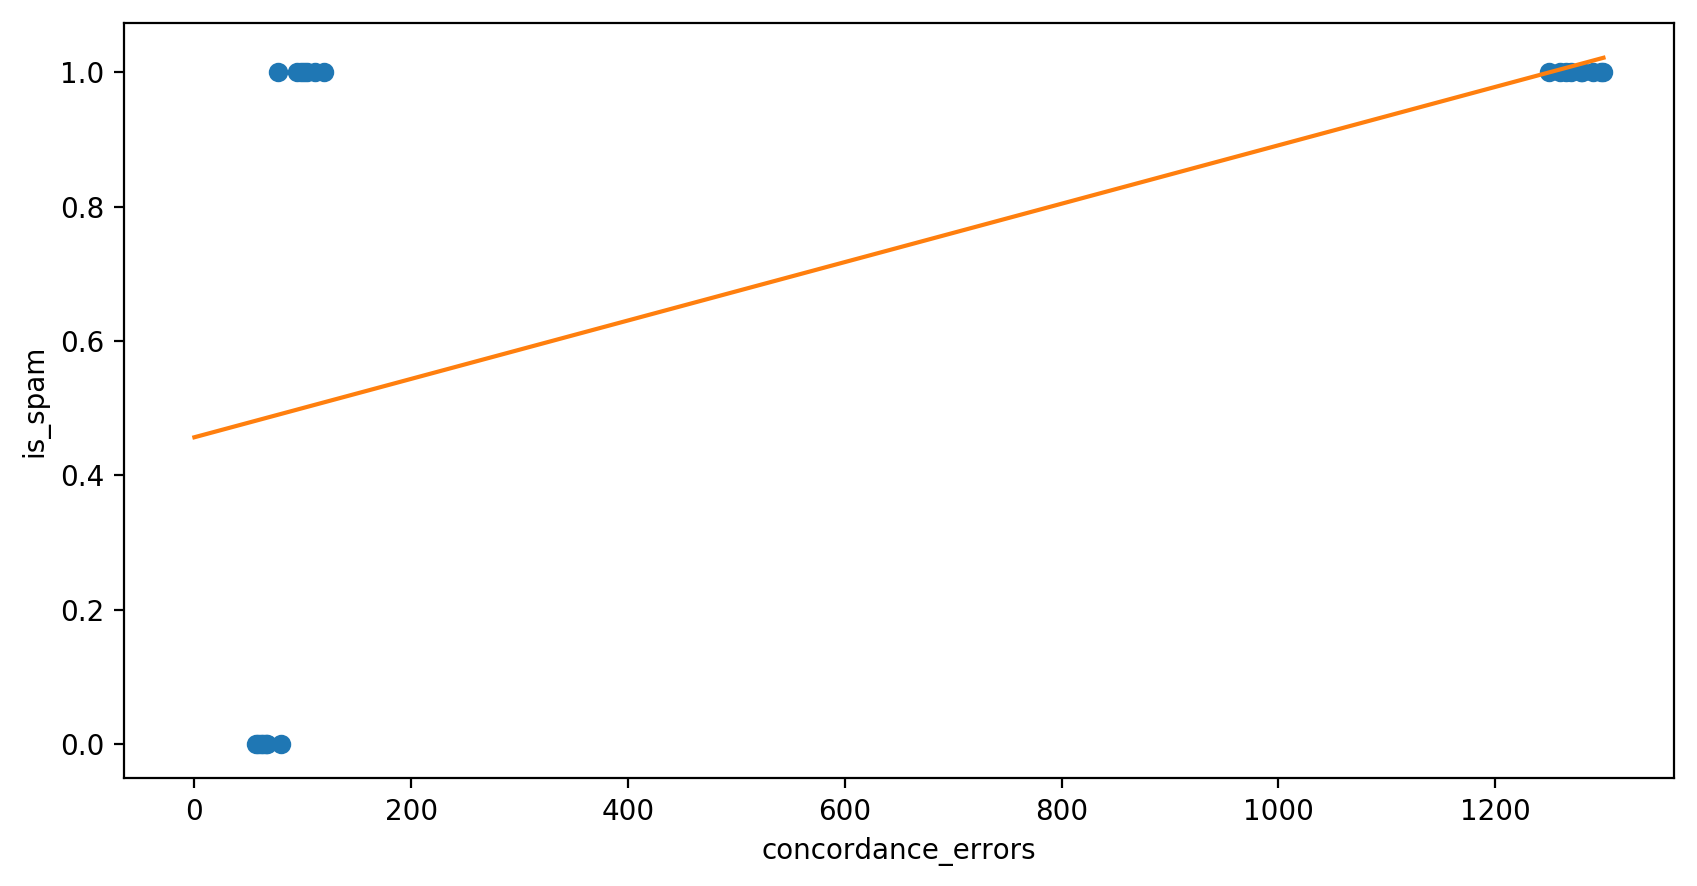

In [122]:
# Creates the canvas
fig, axes = plt.subplots(figsize=(10, 5), dpi= 200)

# Really plots the data
axes.plot(changed_ccr, changed_spam, 'o')
axes.set_xlabel('concordance_errors')
axes.set_ylabel('is_spam')

reg = linear_model.LinearRegression()

# Prepare our data
X = np.expand_dims(changed_ccr, axis=1)
Y = changed_spam

# Now we use the `reg` object to learn the best line
reg.fit(X, Y)

# Now we will plot the data
# Define a line using the slope and intercept that we got from the previous snippet
x = np.linspace(0, 1300, 300)
y = reg.coef_ * x + reg.intercept_

# Plots the line
axes.plot(x, y)

In [128]:
# Notice how the line crosses '0.5' at a value close to 100
print(x[22], y[22])
print(x[23], y[23])

95.65217391304347 0.49824057977274006
100.0 0.5001295051783501


You can see that, as the number of data points to the right increases, the line is going to get farther and farther from the previously "good" division at the point $y = 0.5$. Still, it shouldn't matter how many points to the right we have: even if an email has millions of concordance errors, it should be taken as a spam.

In cases like this, it might be a better fit to use `Logistic Regression`. The code below shows how to do it in Python (and shows what it would look like for the data above:

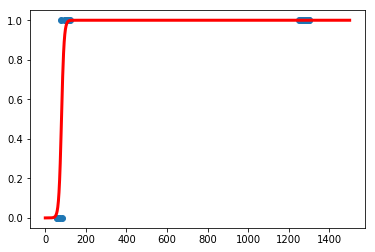

In [130]:
# Take a look at
# http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
# for more details on how Logistic Regression is implemented in scikit-learn

fig, axes = plt.subplots()
axes.plot(changed_ccr, changed_spam, 'o')

# LogisticRegression() returns an object that we will use to do regression
# (C is a parameter that you might have to tweak a little to fit your data)
reg = linear_model.LogisticRegression(C=1e5)

# Prepare our data
X = np.expand_dims(changed_ccr, axis=1)
Y = changed_spam

# Now we use the `reg` object to learn the best line
reg.fit(X, Y)

# Adapted from http://scikit-learn.org/stable/auto_examples/linear_model/plot_logistic.html
def model(a):
    return 1 / (1 + np.exp(-a))

x = np.linspace(0, 1500, 1000)
y = model(x * reg.coef_[0] + reg.intercept_)
axes.plot(x, y, color='red', linewidth=3)

But what is it that Logistic Regression is doing?

We saw before that, in the case of Linear Regression, we had a function that looked like

$$
\mathbf{y} = A\mathbf{x} + b + \boldsymbol{\epsilon}
$$

and wanted to find a configuration of $A$ and $b$ for which the $\boldsymbol{\epsilon}$ was "the best" (i.e., was minimum, according to a certain useful definition of "minimum").

What we are doing in Logistic Regression is almost the same, but instead of having a linear function, we change it so that it has two useful properties:

 * **First**, we want it to be between 0 and 1. Isn't very weird that, when we apply Linear Regression, we still get values that are much smaller than 0 and much bigger than 1? It is actually quite hard to interpret what these values are supposed to mean. Is a spam that has millions of `concordance_errors` much more "spammy" than one that has just 1000?

 * **Second**, we want it to have a nice boundary that does not get affected much by values that are too far away from the boundary.

In Machine Learning, there is a function that fulfill these two desired properties: the _Logistic_ function (a.k.a. the Sigmoid function). Its equation looks like this:

$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$

So, basically, what we want to do is exactly what we were doing before, with the only difference that our function is changed to reflect the fact that we don't want a straight line, but rather a sigmoid function:

$$
\mathbf{y} = \sigma(A\mathbf{x} + b) + \boldsymbol{\epsilon}
$$

In the equation above, $\sigma(\cdot)$ receives a vector and applies the sigmoid function to each of the elements of the vector, transforming all of them into a value something between 0 and 1.

### Applying Gradient Descent

Applying Gradient Descent to this new function has a small catch. In the Linear Regression above, we were trying to find values of $A$ and $b$ for which the $L_2$-norm of the $\boldsymbol{\epsilon}$ vector was the smallest possible. We were lucky because this error function was always "convex", and we were almost always sure to find the global minimum.

Unfortunately, when we transform the equation above with the Logistic function, applying this optimization doesn't always lead us to a global minimum. Instead, we would likely arrive in a local minimum (see discussion on the caveats of Gradient Descent above).

To change this into a convex problem again, we need a different error function. Sadly, this new error function makes our math much uglier. So far, all our error functions looked something like this:

$$
E_{general} = \sum_i{Cost_i}
$$

where the cost was normally related to that $\boldsymbol{\epsilon}$ vector. In the case of Logistic Regression, we will ignore the $\boldsymbol{\epsilon}$ and focus on the other two terms: the expected output $\mathbf{y}$, and our predictions $\sigma(A\mathbf{x} + b)$ (which we will refer to by $\hat{\mathbf{y}}$). Our new error function will look like:

$$
\text{Cross-Entropy between }\mathbf{y}\text{ and }\hat{\mathbf{y}}
\\H(\mathbf{y}, \hat{\mathbf{y}}) = -\sum_i{y_i\log(\hat{y}_i) + (1 - y_i)\log(1 - \hat{y}_i)}
$$

One could try to understand the Cross-Entropy as a measure of how distant the vector $\hat{\mathbf{y}}$ (the "prediction" of our model) is from the vector $\mathbf{y}$ (the vector we have in our data).

Training (part 3): Classification
---------------------------------

You can interpret the Logistic Regression from the previous section as a "Classification" procedure. These terms are not super well divided in the Machine Learning literature. One important difference, however, is that, with Logistic Regression, you consider that there is some sort of "underlying continuum" between the two values you are trying to classify. For example, you might be trying to classify between "positive" and "negative" tweets, and there might be tweets that are actually neither "positive" nor "negative". But in the case of Classification you have classes that are not necessarily in opposition to each other.

For example, given a piece of text (say, a handwritten text, or even an email), you might want to decide if it was written by, say, John, Philipp, Christy, or was a spam. In this case, you can still use Logistic Regression to train several _one-vs-all_ classifiers. You can then decide to assign the class of a certain item to the class whose classifier was the most confident.

![one-vs-all classification](onevsall_classification.png "How would this classification look like")

For example, given the image above, you could ask yourself what would be the class of a new point that appears among the blue points. Since it is among the blue points, it is very likely also a blue one. But how would you know this from the results you get?

![one-vs-all classification2](onevsall_classification2.png "How would this classification look like")


If you calculate the Logistic Regression value for the pink dot for each one of the three lines we saw above, you will that:

 * For the first line, it is very close to 1
 * For the second line, it is also very close to 0
 * For the third line, it is very close to 0

Notice that the first line corresponds to the class of the blue points. So it is just natural to assume that the class of the pink dot is blue.

In more formal terms, if you consider that there is a set $C$ of $k$ lines (classes), then you want to pick the class $c$ for which the Logistic Regression is the biggest. That is:

$$
\text{argmax}_{c \in C}\hat{y}_c
$$

Finally, you might want to calculate something that you could interpret as a "probability" that the pink is part of any of the classes (red, green or blue). I won't go into details ([you can find them in a blog post I wrote some time ago](https://jcbgamboa.github.io/2018/01/31/the-multiple-facets-of-arrays/)), but basically what you can is the following. Let's say that each of the $k$ elements are in a vector. Let's call this the $scores$ vector:

$$
scores = (s_1, s_2, \dots, s_k)
$$

We want a function that would take whatever values are in these scores, and convert them into values that sum to $1$. There is a nice fancy function, called _softmax_, that does this. It creates a new vector of $scores$ in the following way:

$$
softmaxedScores_i = \frac{e^{s_i}}{\sum_{j = 0}^{k}{e^{s_j}}}
$$

(This is **the right way** to transform scores into probabilities [again, see my blog post for whys](https://jcbgamboa.github.io/2018/01/31/the-multiple-facets-of-arrays/)).

### Classification through Logistic Regression in Python

Applying this kind of Classification in Python is just the same as before. The `LogisticRegression` checks if it received only 2 classes, or many. If it received many, it outputs several `intercept`s and `slope`s, each one of which corresponds to a different line.